LOAD PYTHON PACKAGES

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install indic-nlp-library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18.1
    Uninstalling docutils-0.18.1:
      Successfully uninstalled docutils-0.18.1
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 5.0.2
    Uninstalling Sphinx-5.0.2:
      Successfully uninstalled Sphinx-5.0.2


In [ ]:
!pip install punjabi_stopwords

In [ ]:
!pip install LiHiSTO

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for LiHiSTO: filename=LiHiSTO-0.0.2-py3-none-any.whl size=6622 sha256=e4daf6dc9c171179d056e9b24fe21d6fad584ba35b367457d1163a4098b55f4d
  Stored in directory: /root/.cache/pip/wheels/30/4b/ee/9455c8f022cf1934fe774cbfd84b699cacca35d6fce0b7f60e
Successfully built LiHiSTO


In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.5 MB/s eta 0:00:00


In [ ]:
!pip install wordcloud

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
from indicnlp.tokenize import indic_tokenize
from punjabi_stopwords import remove_stopwords
from stopwords_hindi import hindi_sw
import emoji
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

LOAD DATA INTO MEMORY

In [ ]:
tweets_file_name = 'farmers-protest-tweets.json'

tweets_set = []
with open(tweets_file_name, 'r') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            tweets_set.append(tweet)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

print(f"Successfully loaded {len(tweets_set)} tweets.")

Successfully loaded 117407 tweets.


In [ ]:
language_count = {}

for tweet in tweets_set:
    lang = tweet.get('lang', 'unknown')  # Obtaining the language "unkown" in case it does not exist
    if lang in language_count:
        language_count[lang] += 1  # Increment de language count in case it is already in the dictionary
    else:
        language_count[lang] = 1  # Initialize the key in the dictionary
sorted_language_count = sorted(language_count.items(), key=lambda item: item[1], reverse=True)

for lang, count in sorted_language_count:
    print(f"{lang}: {count} tweets")


en: 48429 tweets
und: 35372 tweets
hi: 17880 tweets
pa: 10028 tweets
in: 1823 tweets
tl: 527 tweets
et: 524 tweets
ta: 451 tweets
kn: 265 tweets
ht: 222 tweets
mr: 187 tweets
es: 176 tweets
ur: 131 tweets
gu: 126 tweets
ml: 110 tweets
te: 103 tweets
fr: 92 tweets
tr: 86 tweets
it: 73 tweets
bn: 73 tweets
pt: 69 tweets
da: 64 tweets
hu: 60 tweets
de: 58 tweets
fi: 54 tweets
ne: 50 tweets
nl: 44 tweets
sl: 39 tweets
ca: 35 tweets
ro: 32 tweets
sv: 31 tweets
eu: 30 tweets
lv: 30 tweets
cy: 25 tweets
no: 22 tweets
cs: 21 tweets
or: 18 tweets
lt: 14 tweets
pl: 11 tweets
is: 7 tweets
vi: 5 tweets
ja: 4 tweets
ru: 3 tweets
ar: 1 tweets
fa: 1 tweets
si: 1 tweets


PREPROCESS THE DOCUMENT:

Removing stop words
● Tokenization
● Removing punctuation marks
● Stemming
● and... anything else you think it's needed (bonus point)

In [ ]:
def remove_emojis(text):
    return emoji.replace_emoji(text, "")


In [ ]:
def combine_hashtags(tokens):
    combined_tokens = []
    i = 0

    while i < len(tokens):
        if tokens[i].startswith('#') and i + 1 < len(tokens):
            # Combines de # with the next token
            combined_tokens.append(f"{tokens[i]}{tokens[i + 1]}")
            i += 2
        else:
            combined_tokens.append(tokens[i])
            i += 1

    return combined_tokens

In [ ]:
def combine_at(tokens):  #The same code as before but with the @ of the users
  combined_at = []
  i=0

  while i < len(tokens):
    if tokens[i].startswith('@') and i + 1 < len(tokens):
      combined_at.append(f"{tokens[i]}{tokens[i+1]}")
      i += 2
    else:
      combined_at.append(tokens[i])
      i += 1

  return combined_at

In [ ]:
def remove_punctuation_mixed(tokens):
    punctuation_list = [',','-','.','|','!','?','!!',':','...','=','/', ';', '(', ')', "'", "।"]
    punct_pattern = r"^[{}]+|[{}]+$".format(re.escape(''.join(punctuation_list)), re.escape(''.join(punctuation_list)))
    cleaned_tokens = []

    for token in tokens:
        # Remove punctuation using regex
        cleaned_token = re.sub(punct_pattern, '', token)
        # Add the cleaned token
        cleaned_tokens.append(cleaned_token)

    return cleaned_tokens

In [ ]:
stop_words_english = set(stopwords.words('english'))
stop_words_indonesian = set(stopwords.words('indonesian'))
stop_words_hindi = hindi_sw.get_hindi_sw()

from punjabi_stopwords import remove_stopwords  # Import your stopwords removal function

def build_terms(tweet):
    """
    Preprocess the tweet text (removing stop words, stemming,
    transforming to lowercase and returning the tokens).

    Arguments:
    tweet -- dictionary containing 'content' (text) and 'lang' (language)

    Returns:
    tokens - a list of tokens corresponding to the input text after preprocessing
    """

    line = tweet['content']
    lang = tweet['lang']

    stemmer = PorterStemmer()

    # Transform to lowercase
    line = line.lower()
    line = remove_emojis(line) #additionally we decided to also remove emojis from the text, since they are not relevant for the search

    line = re.sub(r'https://[^\s]+', '', line)

    # Tokenize based on the language
    if lang in ['pa', 'hi']:  # Hindi and Punjabi
        tokens = indic_tokenize.trivial_tokenize(line)  # Tokenize for Punjabi
        tokens = combine_hashtags(tokens)
        tokens = combine_at(tokens)
    else:  # English and Indonesian
        tokens = line.split()

    tokens = remove_punctuation_mixed(tokens)


    # Remove stopwords based on language
    if lang == 'en':
        tokens = [x for x in tokens if x not in stop_words_english]
    elif lang == 'id':
        tokens = [x for x in tokens if x not in stop_words_indonesian]
    elif lang == 'hi':
        tokens = [x for x in tokens if x not in stop_words_hindi]
    elif lang == 'pa':
        # Join tokens into a single string for stopword removal
        text_string = ' '.join(tokens)
        filtered_text = remove_stopwords(text_string)  # Remove stopwords
        tokens = filtered_text.split()

    tokens = [x for x in tokens if x not in [',','-','.','|','!','?','!!',':','...','=','/', ';', '(', ')', "'", "।", '\n', '', '_', '"','&amp', '\n\n']] #extra layer of purification upon inspecting the most frequent tokens
    # Perform stemming
    tokens = [stemmer.stem(x) for x in tokens]

    return tokens


PUNJABI EXAMPLE

In [ ]:
tweets_set[2]

{'url': 'https://twitter.com/parmarmaninder/status/1364506195453767680',
 'date': '2021-02-24T09:23:22+00:00',
 'content': "ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜਾਣ ਨਾਲੋਂ ਬਿਹਤਰ ਆ ਭਾਰਤ 'ਚ ਪੈਟਰੋਲ ਪੰਪ ਪਾ ਲਈਏ। 🤫🤫🤔🤔\n#FarmersProtest",
 'renderedContent': "ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇਰੇ ਹਿਸਾਬ ਨਾਲ ਬਾਹਰ(ਪ੍ਰਦੇਸ਼) ਜਾਣ ਨਾਲੋਂ ਬਿਹਤਰ ਆ ਭਾਰਤ 'ਚ ਪੈਟਰੋਲ ਪੰਪ ਪਾ ਲਈਏ। 🤫🤫🤔🤔\n#FarmersProtest",
 'id': 1364506195453767680,
 'user': {'username': 'parmarmaninder',
  'displayname': 'maninder singh',
  'id': 476006247,
  'description': '।।ਨਾਨਕ ਨਾਮ ਚੜ੍ਹਦੀ ਕਲਾ ਤੇਰੈ ਭਾਣੈ ਸਰਬੱਤ ਦਾ ਭਲਾ।।',
  'rawDescription': '।।ਨਾਨਕ ਨਾਮ ਚੜ੍ਹਦੀ ਕਲਾ ਤੇਰੈ ਭਾਣੈ ਸਰਬੱਤ ਦਾ ਭਲਾ।।',
  'descriptionUrls': [],
  'verified': False,
  'created': '2012-01-27T17:30:27+00:00',
  'followersCount': 72,
  'friendsCount': 151,
  'statusesCount': 2285,
  'favouritesCount': 846,
  'listedCount': 0,
  'mediaCount': 265,
  'location': '',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'p

In [ ]:
build_terms(tweets_set[2])

['ਪੈਟਰੋਲ',
 'ਕੀਮਤਾਂ',
 'ਮੱਦੇਨਜ਼ਰ',
 'ਰੱਖਦੇ',
 'ਮੇਰੇ',
 'ਹਿਸਾਬ',
 'ਬਾਹਰ',
 'ਪ੍ਰਦੇਸ਼',
 'ਜਾਣ',
 'ਨਾਲੋਂ',
 'ਬਿਹਤਰ',
 'ਭਾਰਤ',
 'ਚ',
 'ਪੈਟਰੋਲ',
 'ਪੰਪ',
 'ਪਾ',
 'ਲਈਏ',
 '#farmersprotest']

ENGLISH EXAMPLE

In [ ]:
tweets_set[0]

{'url': 'https://twitter.com/ArjunSinghPanam/status/1364506249291784198',
 'date': '2021-02-24T09:23:35+00:00',
 'content': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur https://t.co/es3kn0IQAF',
 'renderedContent': 'The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. \n\n@narendramodi @DelhiPolice Shame on you. \n\n#ModiDontSellFarmers \n#FarmersProtest \n#FreeNodeepKaur twitter.com/ravisinghka/st…',
 'id': 1364506249291784198,
 'user': {'username': 'ArjunSinghPanam',
  'displayname': 'Arjun Singh Panam',
  'id': 45091142,
  'description': 'Global Citizen, Actor, Director: Sky is the roof above my head, the world is the road I travel, love is my food & mother earth is my bed. Roy in @CosmosMovie',
  'rawDescription':

In [ ]:
build_terms(tweets_set[0])

['world',
 'progress',
 'indian',
 'polic',
 'govt',
 'still',
 'tri',
 'take',
 'india',
 'back',
 'horrif',
 'past',
 'tyranni',
 '@narendramodi',
 '@delhipolic',
 'shame',
 '#modidontsellfarm',
 '#farmersprotest',
 '#freenodeepkaur']

INDONESIAN EXAMPLE

In [ ]:
count=0
i=0
for tweet in tweets_set:
    if tweet['lang'] == 'in':
        count = i
        break
    i += 1
print(count)


139


In [ ]:
tweets_set[139]

{'url': 'https://twitter.com/SandeepLakha11/status/1364499171831549953',
 'date': '2021-02-24T08:55:28+00:00',
 'content': '@GoluBha42573817 @pinkichaubey Toh salayeo ehnke liye hi kuch krlo agar yeh b sadko pr aa gye fir tum log modi bhagti hi kroge  . Andh bhgto  #FarmersProtest',
 'renderedContent': '@GoluBha42573817 @pinkichaubey Toh salayeo ehnke liye hi kuch krlo agar yeh b sadko pr aa gye fir tum log modi bhagti hi kroge  . Andh bhgto  #FarmersProtest',
 'id': 1364499171831549953,
 'user': {'username': 'SandeepLakha11',
  'displayname': 'Sandeep Lakha',
  'id': 1334192494255374336,
  'description': '',
  'rawDescription': '',
  'descriptionUrls': [],
  'verified': False,
  'created': '2020-12-02T17:48:21+00:00',
  'followersCount': 38,
  'friendsCount': 115,
  'statusesCount': 263,
  'favouritesCount': 619,
  'listedCount': 0,
  'mediaCount': 16,
  'location': '',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'profileImageUrl': 'https://pbs.twimg.com/profile_i

In [ ]:
build_terms(tweets_set[139])

['@golubha42573817',
 '@pinkichaubey',
 'toh',
 'salayeo',
 'ehnk',
 'liy',
 'hi',
 'kuch',
 'krlo',
 'agar',
 'yeh',
 'b',
 'sadko',
 'pr',
 'aa',
 'gye',
 'fir',
 'tum',
 'log',
 'modi',
 'bhagti',
 'hi',
 'kroge',
 'andh',
 'bhgto',
 '#farmersprotest']

HINDI EXAMPLE

In [ ]:
tweets_set[21]

{'url': 'https://twitter.com/rajraka/status/1364505444606119940',
 'date': '2021-02-24T09:20:23+00:00',
 'content': 'आज कल लोग मेरी पोस्ट को ऐसे इग्नोर कर रहे है जैसे पेट्रोल के दाम मैने ही बढ़ाया है...🙄🙄\n#FarmersProtest',
 'renderedContent': 'आज कल लोग मेरी पोस्ट को ऐसे इग्नोर कर रहे है जैसे पेट्रोल के दाम मैने ही बढ़ाया है...🙄🙄\n#FarmersProtest',
 'id': 1364505444606119940,
 'user': {'username': 'rajraka',
  'displayname': 'Raj',
  'id': 116396264,
  'description': 'Dance // Travel lover.',
  'rawDescription': 'Dance // Travel lover.',
  'descriptionUrls': [],
  'verified': False,
  'created': '2010-02-22T08:55:45+00:00',
  'followersCount': 285,
  'friendsCount': 1608,
  'statusesCount': 3014,
  'favouritesCount': 7365,
  'listedCount': 1,
  'mediaCount': 129,
  'location': 'जींद हरियाणा',
  'protected': False,
  'linkUrl': None,
  'linkTcourl': None,
  'profileImageUrl': 'https://pbs.twimg.com/profile_images/1150677137067655168/xUylBqQ0_normal.jpg',
  'profileBannerUrl': 'https://

In [ ]:
build_terms(tweets_set[21])

['लोग',
 'मेरी',
 'पोस्ट',
 'इग्नोर',
 'पेट्रोल',
 'दाम',
 'मैने',
 'बढ़ाया',
 '#farmersprotest']

HINT 1:

In [ ]:
def find_pattern(tweet, pattern):
    hashtags = []
    for token in tweet:
        if re.match(pattern, token):
            hashtags.append(token)
    return hashtags

In [ ]:
mapping_doc_path = 'tweet_document_ids_map.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(mapping_doc_path)

id_to_number = dict(zip(df['id'], df['docId']))

OPTION ONE: CREATING A LIST

In [ ]:
def process_tweets_option1(set):
    lastid = len(id_to_number.keys())
    processed = []
    for i in range(len(set)):
        if set[i]['id'] in id_to_number.keys():
            doc_num = id_to_number[set[i]['id']]
        else:
            lastid += 1
            newid= f'doc_{lastid}'
            while newid in id_to_number.keys():#security measure for if there is a skipped number
                lastid += 1
                newid= f'doc_{lastid}'
            doc_num = newid
        processed_text = list(build_terms(set[i]))
        wo_processing = set[i]['content']
        date = set[i]['date']
        hashtags = find_pattern(processed_text, r'^#')
        likes = set[i]['likeCount']
        num_retweet = set[i]['retweetCount']
        tweet_url = set[i]['url']
        tweet_user = set[i]['user']['username']

        tweet_dict = {'docNum': doc_num, 'id': set[i]['id'], 'tweet': wo_processing, 'date': date, 'hashtags': hashtags, 'likes': likes, 'retweets': num_retweet,'url': tweet_url, 'tokenizedContent': processed_text, 'userName':tweet_user}
        processed.append(tweet_dict)

    return processed

In [ ]:
processed_tweets1 = process_tweets_option1(tweets_set)

In [ ]:
num_processed_tweets = len(processed_tweets1)
print(num_processed_tweets)

117407


In [ ]:
processed_tweets1[1]

{'docNum': 'doc_1',
 'id': 1364506237451313155,
 'tweet': "#FarmersProtest \n#ModiIgnoringFarmersDeaths \n#ModiDontSellFarmers \n@Kisanektamorcha \nFarmers constantly distroying crops throughout India. \nReally, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE",
 'date': '2021-02-24T09:23:32+00:00',
 'hashtags': ['#farmersprotest',
  '#modiignoringfarmersdeath',
  '#modidontsellfarm'],
 'likes': 0,
 'retweets': 0,
 'url': 'https://twitter.com/PrdeepNain/status/1364506237451313155',
 'tokenizedContent': ['#farmersprotest',
  '#modiignoringfarmersdeath',
  '#modidontsellfarm',
  '@kisanektamorcha',
  'farmer',
  'constantli',
  'distroy',
  'crop',
  'throughout',
  'india',
  'realli',
  'heart',
  'breaking...w',
  'care',
  'crop',
  'like',
  'children',
  'govt',
  'agricultur',
  'minist',
  'laugh',
  'usw',
  'win'],
 'userName': 'PrdeepNain'}

OPTION 2: CREATING A DICTIONARY OF DICTIONARIES

In [ ]:
def process_tweets_option2(set):
    lastid = len(id_to_number.keys())
    processed = {}  # Initialize an empty dictionary
    for i in range(len(set)):
        if set[i]['id'] in id_to_number.keys():
            doc_num = id_to_number[set[i]['id']]
        else:
            lastid += 1
            newid = f'doc_{lastid}'
            while newid in id_to_number.keys():
                lastid += 1
                newid = f'doc_{lastid}'
            doc_num = newid

        processed_text = list(build_terms(set[i]))
        wo_processing = set[i]['content']
        date = set[i]['date']
        hashtags = find_pattern(processed_text, r'^#')
        likes = set[i]['likeCount']
        num_retweet = set[i]['retweetCount']
        tweet_url = set[i]['url']
        tweet_user = set[i]['user']['username']

        tweet_dict = {
            'docNum': doc_num,
            'id': set[i]['id'],
            'tweet': wo_processing,
            'date': date,
            'hashtags': hashtags,
            'likes': likes,
            'retweets': num_retweet,
            'url': tweet_url,
            'tokenizedContent': processed_text,
            'userName': tweet_user
        }

        processed[doc_num] = tweet_dict

    return processed

In [ ]:
processed_tweets2 = process_tweets_option2(tweets_set)

In [ ]:
processed_tweets2['doc_1']['tweet']

"#FarmersProtest \n#ModiIgnoringFarmersDeaths \n#ModiDontSellFarmers \n@Kisanektamorcha \nFarmers constantly distroying crops throughout India. \nReally, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE"

##**Exploratory data analysis**##

In [ ]:
all_tokens = []
for tweet in processed_tweets1:
    all_tokens.extend(tweet['tokenizedContent'])

In [ ]:
token_counts = {}
for token in all_tokens:
    if token in token_counts.keys():
        token_counts[token] += 1
    else: token_counts[token] = 1

In [ ]:
sorted_tokens = dict(sorted(token_counts.items(), key=lambda item:item[1], reverse=True))
print(sorted_tokens)

{'#farmersprotest': 120577, 'farmer': 16516, 'support': 6693, 'किसान': 6415, 'india': 6168, '#releasedetainedfarm': 5961, '#farmersmakeindia': 5267, 'protest': 4913, '#mahapanchayatrevolut': 4783, '#repealonlywayahead': 4565, '#indiabeingsilenc': 4438, '#standwithfarm': 3675, 'right': 3611, 'peopl': 3412, '#farmer': 3374, 'modi': 3168, '#railrokoforfarm': 3122, '#disharavi': 3098, 'indian': 2958, '#istandwithfarm': 2900, '#freenodeepkaur': 2813, '#msplawforallcrop': 2805, '#modiignoringfarmersdeath': 2790, '#pagdi_sambhal_jatta': 2768, 'ਦੀ': 2712, 'bjp': 2686, 'govern': 2590, 'law': 2576, '#dpstopintimidatingfarm': 2570, 'jai': 2509, 'किसानों': 2458, '#kisanandolan': 2305, 'govt': 2285, 'stand': 2248, '@narendramodi': 2232, '#farmersprostest': 2194, 'आंदोलन': 2178, 'thank': 2142, 'pleas': 2093, '#freedisharavi': 2064, '#gobackmodi': 2034, 'hai': 2022, 'farm': 2007, 'ਕਿਸਾਨ': 2001, 'like': 1978, 'need': 1934, 'world': 1895, 'one': 1863, 'us': 1835, 'arrest': 1833, '@kisanektamorcha': 179

In [ ]:
filtered_tokens = {}

for token in sorted_tokens.keys():
    if token.startswith('@') or token.startswith('#'):
        continue
    if not token.isascii():
        continue
    filtered_tokens[token]=sorted_tokens[token]


(-0.5, 799.5, 399.5, -0.5)

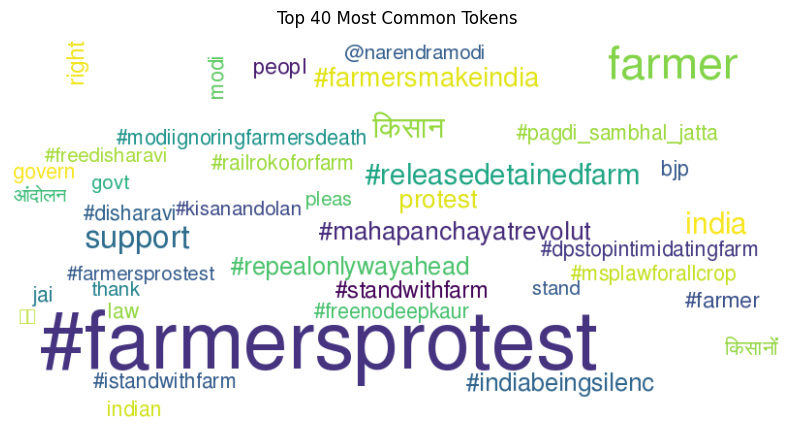

In [ ]:
font = "gargi.ttf"

wordcloud = WordCloud(
    width=800,         # width of the word cloud
    height=400,        # height of the word cloud
    background_color='white',  # background color
    colormap='viridis',         # color scheme for the words
    font_path= font,
    max_words=100)
wordcloud.generate_from_frequencies(dict(list(sorted_tokens.items())[:40]))

plt.figure(figsize=(10,6))
plt.title(f"Top 40 Most Common Tokens")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

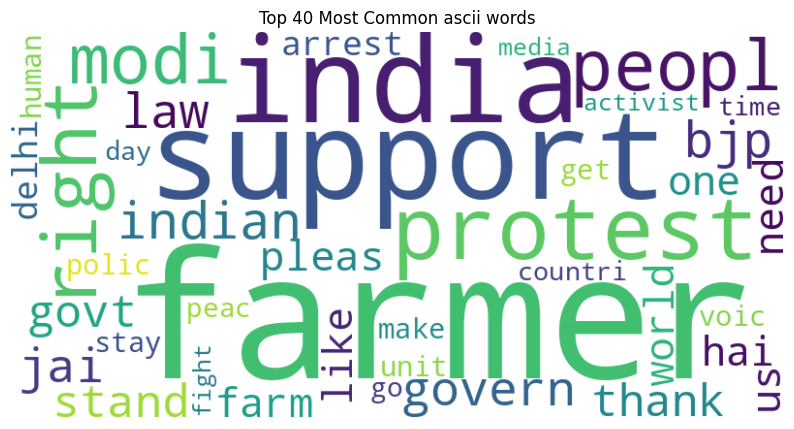

In [ ]:
wordcloud = WordCloud(
    width=800,         # width of the word cloud
    height=400,        # height of the word cloud
    background_color='white',  # background color
    colormap='viridis',         # color scheme for the words
    max_words=100)
wordcloud.generate_from_frequencies(dict(list(filtered_tokens.items())[:40]))

plt.figure(figsize=(10,6))
plt.title(f"Top 40 Most Common ascii words")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.axis('off')

In [ ]:
retweetsList = []
likesList = []

for tweet in processed_tweets1:
    retweetsList.append(tweet['retweets'])
    likesList.append(tweet['likes'])

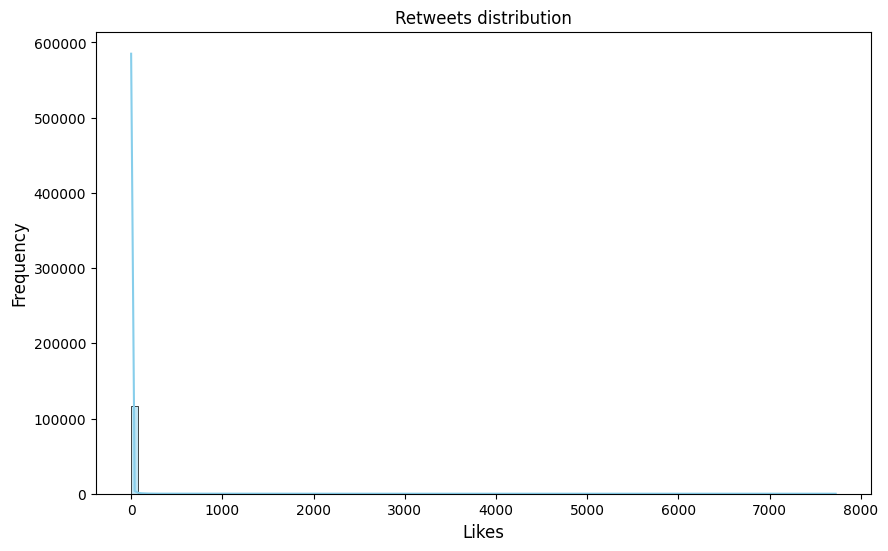

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(retweetsList, bins=100, kde=True, color="skyblue")
plt.title(f"Retweets distribution")
plt.xlabel("Likes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

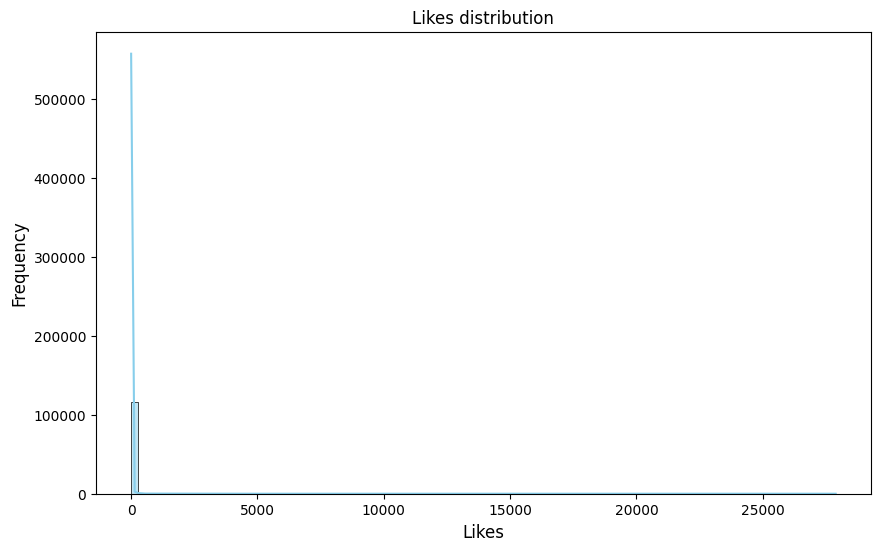

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(likesList, bins=100, kde=True, color="skyblue")
plt.title(f"Likes distribution")
plt.xlabel("Likes", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [ ]:
sorted_tweets_by_likes = sorted(processed_tweets1, key=lambda item:item['likes'], reverse=True)
print('The most liked tweets are the following:')
for i in range(5):
    print('-------> Top', i + 1, 'tweet with ', sorted_tweets_by_likes[i]['likes'],' likes:')
    print(sorted_tweets_by_likes[i]['tweet'])
    print('-------> from user: ', sorted_tweets_by_likes[i]['userName'],'\n')

The most liked tweets are the following:
-------> Top 1 tweet with  27888  likes:
There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
-------> from user:  dhruv_rathee 

-------> Top 2 tweet with  25824  likes:
मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
-------> from user:  RakeshTikaitBKU 

-------> Top 3 tweet with  19284  likes:
लहरों को ख़ामोश देख कर ये ना समझना कि समंदर में रवानी नहीं , हम जब भी उठेंगे तूफ़ान बन कर उठेंगे , बस उठने की अभी ठानी नहीं ... #FarmersProtest                                        #JittegaKisaan
-------> from user:  sherryontopp 

-------> Top 4 tweet with  19198  likes:
हाँ मैं जान

In [ ]:
likesList.sort(reverse=False)
likesList= np.array(likesList)

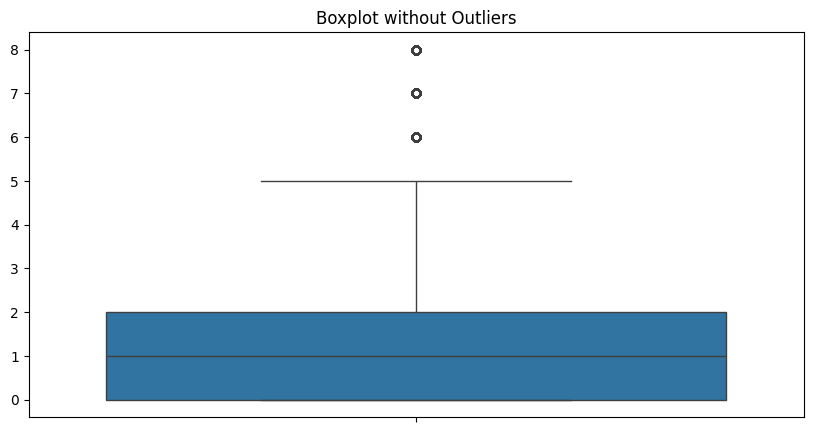

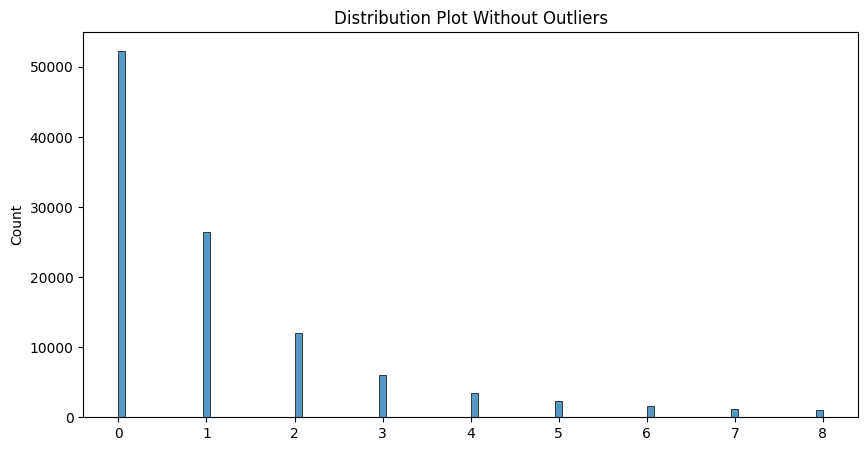

Cleaned Data (Without Outliers): [0 0 0 ... 8 8 8]


In [ ]:
upper_bound = np.percentile(likesList, 90)
cleaned_data = likesList[(likesList <= upper_bound)]
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_data)
plt.title("Boxplot without Outliers (top 10%)")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data, bins=100)
plt.title("Distribution Plot Without Outliers (top 10%)")
plt.show()

# Optional: Print cleaned data for confirmation
print("Cleaned Data (Without Outliers):", cleaned_data)

In [ ]:
no0likes = likesList[likesList > 100]

In [ ]:
print('Out of the ', len(likesList), ' ther are ', len(no0likes), ' tweets with more than 100 likes')

Out of the  117407  ther are  2119  tweets with more than 100 likes


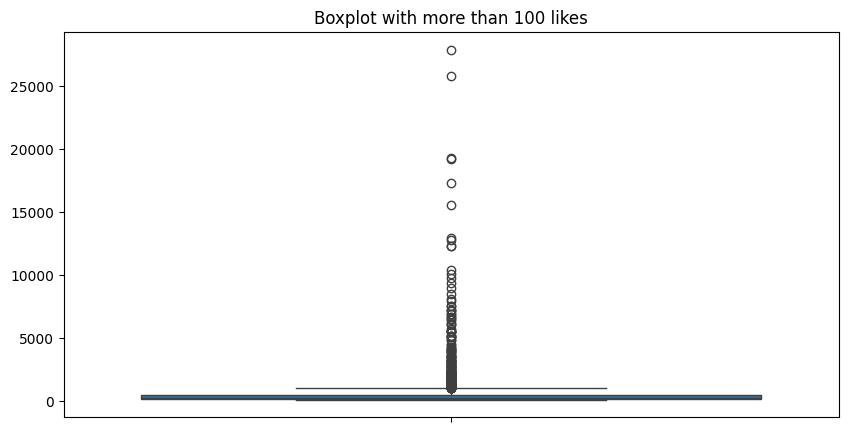

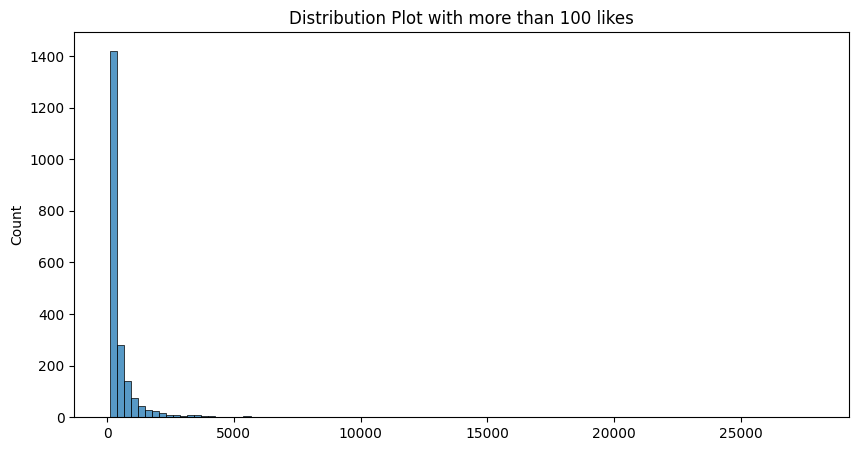

Cleaned Data (Without 0s): [  101   101   101 ... 19284 25824 27888]


In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=no0likes)
plt.title("Boxplot with more than 100 likes")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(no0likes, bins=100)
plt.title("Distribution Plot with more than 100 likes")
plt.show()

# Optional: Print cleaned data for confirmation
print("Cleaned Data (Without 0s):", no0likes)

We will now do the same but for the number of retweets:

In [ ]:
sorted_tweets_by_retweets = sorted(processed_tweets1, key=lambda item:item['retweets'], reverse=True)
print('The most liked tweets are the following:')
for i in range(5):
    print('-------> Top', i + 1, 'tweet with ', sorted_tweets_by_retweets[i]['retweets'],' retweets:')
    print(sorted_tweets_by_retweets[i]['tweet'])
    print('-------> from user: ', sorted_tweets_by_retweets[i]['userName'],'\n')

The most liked tweets are the following:
-------> Top 1 tweet with  7723  retweets:
मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान खरीदकर भाग गया। किसान पैसे के लिए धरना दे रहे है।
अब भी बताना पड़ेगा काला क्या है
#FarmLaws #FarmersProtest #किसान_एकता_जिंदाबाद
-------> from user:  RakeshTikaitBKU 

-------> Top 2 tweet with  6164  retweets:
There's a #FarmersProtest happening in Germany.

But the German Govt didn’t block their path with barbed wires, dig highways or label them Anti-National. And neither did the Govt declare it an ‘internal matter’ where others can’t comment. I guess that’s how democracies work. https://t.co/pZtigTgWT8
-------> from user:  dhruv_rathee 

-------> Top 3 tweet with  4673  retweets:
disha ravi, a 21-year-old climate activist, has been arrested by delhi police for sharing a toolkit @GretaThunberg  posted in support of the #farmersprotest. 

disha’s arrest is alarming and the world needs to pay attention. #freedisharavi

https://t.co/IYGsLpNjwZ
-------> from u

In [ ]:
for i in range(10):
    print('-> Top', i + 1, 'tweet with most retweet, id:', sorted_tweets_by_retweets[i]['docNum'])
    print('-> Top', i + 1, 'tweet with most likes, id:  ', sorted_tweets_by_likes[i]['docNum'])
    print('\n')


-> Top 1 tweet with most retweet, id: doc_113632
-> Top 1 tweet with most likes, id:   doc_3203


-> Top 2 tweet with most retweet, id: doc_3203
-> Top 2 tweet with most likes, id:   doc_113632


-> Top 3 tweet with most retweet, id: doc_38410
-> Top 3 tweet with most likes, id:   doc_83874


-> Top 4 tweet with most retweet, id: doc_38012
-> Top 4 tweet with most likes, id:   doc_65353


-> Top 5 tweet with most retweet, id: doc_46206
-> Top 5 tweet with most likes, id:   doc_46206


-> Top 6 tweet with most retweet, id: doc_27071
-> Top 6 tweet with most likes, id:   doc_62412


-> Top 7 tweet with most retweet, id: doc_45142
-> Top 7 tweet with most likes, id:   doc_45142


-> Top 8 tweet with most retweet, id: doc_83874
-> Top 8 tweet with most likes, id:   doc_96125


-> Top 9 tweet with most retweet, id: doc_65353
-> Top 9 tweet with most likes, id:   doc_88771


-> Top 10 tweet with most retweet, id: doc_62412
-> Top 10 tweet with most likes, id:   doc_38262




In [ ]:
retweetsList.sort(reverse=False)
retweetsList= np.array(retweetsList)

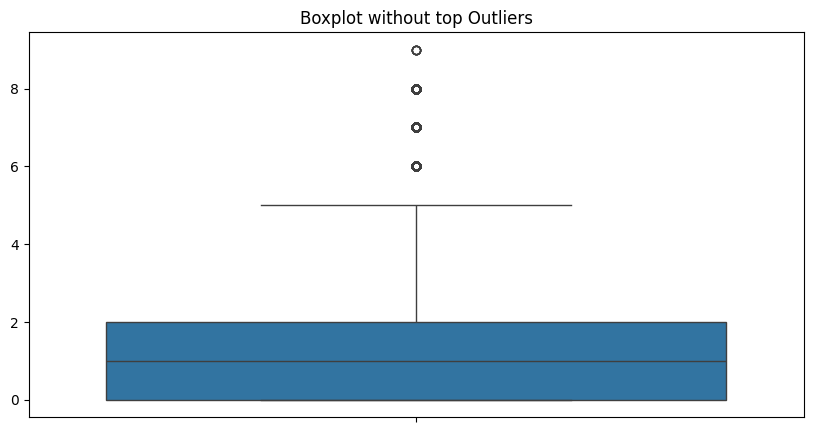

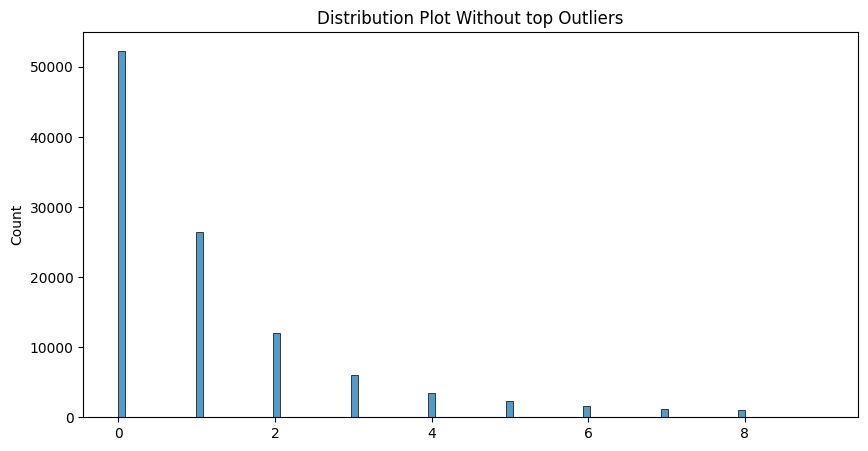

Cleaned Data (Without top Outliers): [0 0 0 ... 9 9 9]


In [ ]:
upper_bound = np.percentile(retweetsList, 90)
cleaned_data = likesList[(retweetsList <= upper_bound)]
plt.figure(figsize=(10, 5))
sns.boxplot(data=cleaned_data)
plt.title("Boxplot without top Outliers")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(cleaned_data, bins=100)
plt.title("Distribution Plot Without top Outliers")
plt.show()

print("Cleaned Data (Without top Outliers):", cleaned_data)

In [ ]:
no0retweets = retweetsList[retweetsList > 100]

In [ ]:
no0retweets

array([ 101,  101,  101, ..., 4673, 6164, 7723])

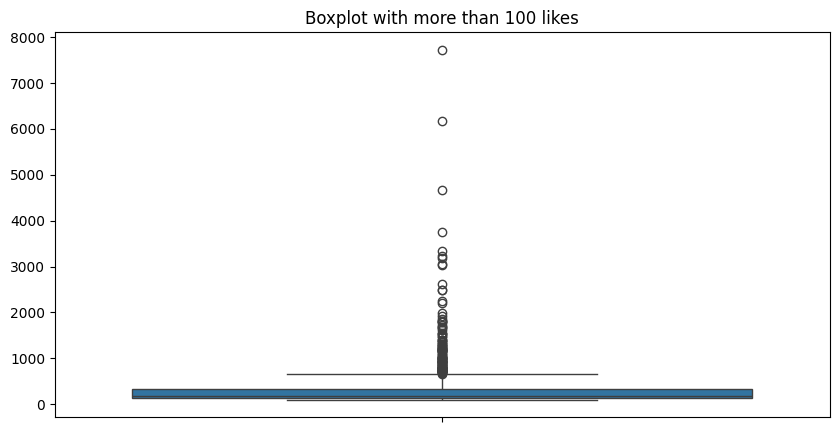

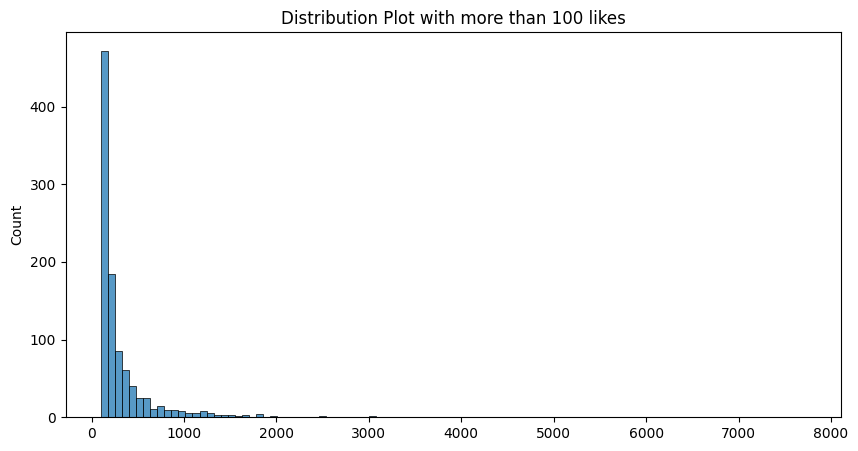

Cleaned Data (with more than 100 likes): [ 101  101  101 ... 4673 6164 7723]


In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=no0retweets)
plt.title("Boxplot with more than 100 likes")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(no0retweets, bins=100)
plt.title("Distribution Plot with more than 100 likes")
plt.show()

print("Cleaned Data (with more than 100 likes):", no0retweets)